In [1]:
!pip install yfinance

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [3]:
# Download with adjusted close as default
data = yf.download(tickers, start='2019-01-01', end='2024-01-01')

# Use 'Close' prices only
close_prices = data['Close'].dropna()
close_prices.tail()


[*********************100%***********************]  4 of 4 completed


Ticker,HDFCBANK.NS,INFY.NS,RELIANCE.NS,TCS.NS
Date,,,,
2023-12-22,1648.341187,1515.323608,1282.525024,3677.839600
2023-12-26,1659.784912,1496.950562,1289.025024,3650.477051
2023-12-27,1680.354126,1519.395874,1293.425049,3665.528564
2023-12-28,1682.277710,1515.081299,1302.775024,3654.660889
2023-12-29,1686.223877,1495.932495,1292.474976,3648.409180


In [5]:
returns = data.pct_change().dropna()
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()


In [6]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = returns / std_dev
    return returns, std_dev, sharpe_ratio


In [7]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix):
    return -portfolio_performance(weights, mean_returns, cov_matrix)[2]

def check_sum(weights):
    return np.sum(weights) - 1


In [18]:
tickers = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS']

# Get clean price data
data = yf.download(tickers, start='2019-01-01', end='2024-01-01')
close_prices = data['Close'].dropna()

# ✅ Important fix: filter for only selected tickers (even if 'Close' had extra ones)
close_prices = close_prices[tickers]

# Calculate returns ONLY for those
returns = close_prices.pct_change().dropna()
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()


[*********************100%***********************]  4 of 4 completed


In [19]:
mean_returns = mean_daily_returns.values
cov_matrix = cov_matrix.values


In [20]:
# Number of assets
num_assets = len(tickers)

# Initial guess: equal weights
init_guess = num_assets * [1. / num_assets]

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': check_sum})

# Bounds: each weight must be between 0 and 1
bounds = tuple((0, 1) for _ in range(num_assets))

# Run the optimizer
optimal = minimize(
    neg_sharpe_ratio,
    init_guess,
    args=(mean_returns, cov_matrix),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)


In [21]:
# Optimal weights
opt_weights = optimal.x

# Get portfolio metrics
ret, vol, sr = portfolio_performance(opt_weights, mean_returns, cov_matrix)

# Display
print("🔧 Optimal Portfolio Allocation:\n")
for i in range(num_assets):
    print(f"{tickers[i]}: {opt_weights[i]*100:.2f}%")

print(f"\n✅ Expected Annual Return: {ret*100:.2f}%")
print(f"📉 Volatility (Risk): {vol*100:.2f}%")
print(f"📈 Sharpe Ratio: {sr:.2f}")


🔧 Optimal Portfolio Allocation:

RELIANCE.NS: 36.25%
TCS.NS: 20.46%
INFY.NS: 38.86%
HDFCBANK.NS: 4.42%

✅ Expected Annual Return: 22.32%
📉 Volatility (Risk): 22.08%
📈 Sharpe Ratio: 1.01


In [22]:
def simulate_random_portfolios(num_portfolios, mean_returns, cov_matrix, num_assets):
    results = np.zeros((3, num_portfolios))  # [volatility, return, Sharpe]
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)

        ret, vol, sr = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0, i] = vol
        results[1, i] = ret
        results[2, i] = sr

    return results, weights_record


In [23]:
# Simulate 10,000 random portfolios
results, weights = simulate_random_portfolios(10000, mean_returns, cov_matrix, num_assets)

# Extract values
volatility = results[0]
returns = results[1]
sharpe = results[2]


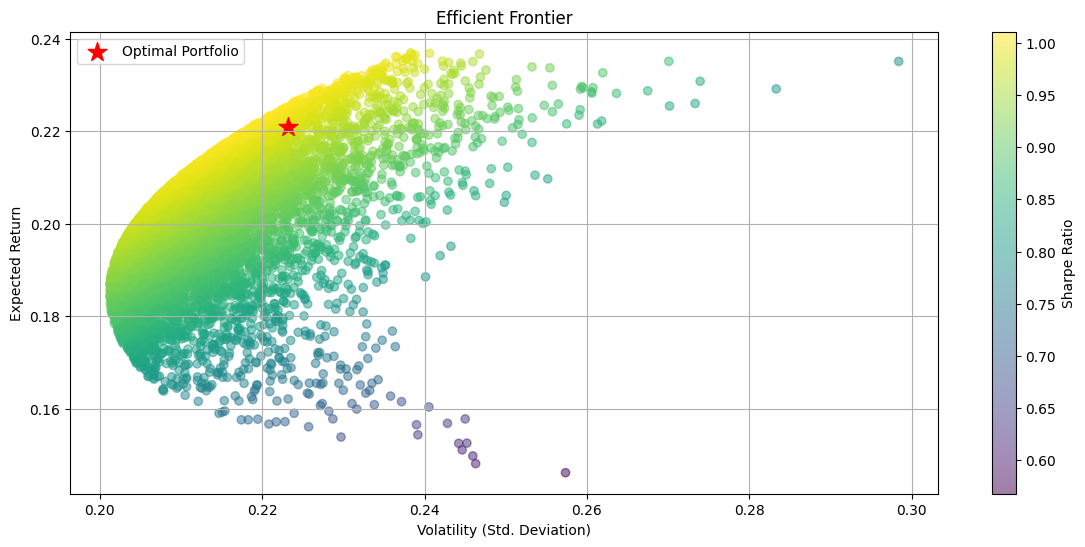

In [24]:
plt.figure(figsize=(14, 6))
scatter = plt.scatter(volatility, returns, c=sharpe, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')

# Highlight optimal portfolio
opt_vol, opt_ret, opt_sr = portfolio_performance(opt_weights, mean_returns, cov_matrix)
plt.scatter(opt_vol, opt_ret, c='red', marker='*', s=200, label='Optimal Portfolio')
plt.legend()
plt.grid(True)
plt.show()
